In [ ]:
# ..... batch effects in data at each time point ..... #

In [2]:
library(Seurat)
library(batchelor)
library(dplyr)
library(bluster)
library(pheatmap)

In [23]:
scnew = readRDS('stage16_integrated_cca.rds')

In [24]:
scnew2 = CreateSeuratObject(counts = LayerData(scnew, assay = 'RNA', layer = 'counts'),
                            meta.data = scnew@meta.data)

scnew2 <- NormalizeData(object = scnew2, normalization.method = "LogNormalize", scale.factor = 10000)
scnew2 <- FindVariableFeatures(scnew2)
scnew2 <- ScaleData(scnew2)
scnew2 <- RunPCA(scnew2, npcs = 30)

# cluster the data
scnew2 <- FindNeighbors(scnew2, dims = 1:15, k = 30)
scnew2 <- FindClusters(object = scnew2, resolution = 0.5, verbose = FALSE)

# run umap
scnew2 <- RunUMAP(object = scnew2, dims = 1:15, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CACNA2D1, SLC8A1, DMD, FGF14, SDK2, RBM20, PALM2AKAP2, RYR2, ERBB4, DIP2C 
	   PTPRD, CTNNA3, SORBS1, QKI, MYH7B, CHRM2, CACNA1C, LDB3, LRRTM3, MAGI1 
	   CDK14, CDH2, PALLD, PPARGC1A, PTPRF, ESRRG, MICAL3, FHOD3, SIPA1L2, FAT1 
Negative:  LOC132782046, LOC132778010, PRDX2, LOC132765014, LOC132761842, LOC132772516, LOC132765340, LOC132770573, SLC25A37, KEL 
	   HMGB2, LOC132774945, TUBB4B, IKZF1, LOC132779389, NPTX1, TMSB4X, LOC132762478, LOC132780323, LOC132780145 
	   LOC132781475, HSPB1, LOC132773086, LOC132780322, SYT9, TAL1, STMN1, SYT6, LOC132763143, CRIP1 
PC_ 2 
Positive:  EBF3, ZNF423, COL3A1, LOC132768920, COL1A2, COL21A1, PXDN, COL1A1, PRKG1, LOC132774264 
	   LAMB1, COL27A1, ADGRG6, EXT1, COL5A1, SPON1, NID1, PREX1, CALCRL, HSPG2 
	   LOC132774269, FBN2, PDGFRA, TSHZ2, UNC5C, RAPGEF5, EPS8, FAT4, PTH1R, MECOM 
Negative:  MYH7B, PLEKHA7, MYH15, LOC13276

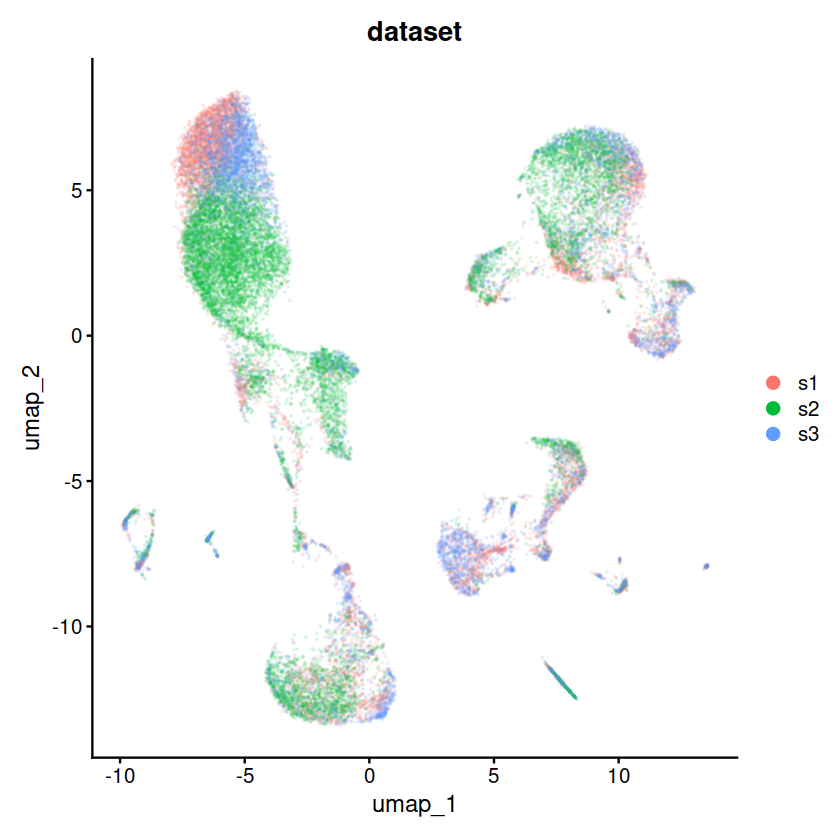

In [25]:
# plot integrated umap
tplot <- DimPlot(scnew2, reduction = "umap", group.by = "dataset")
tplot[[1]]$layers[[1]]$aes_params$alpha =  .1
tplot

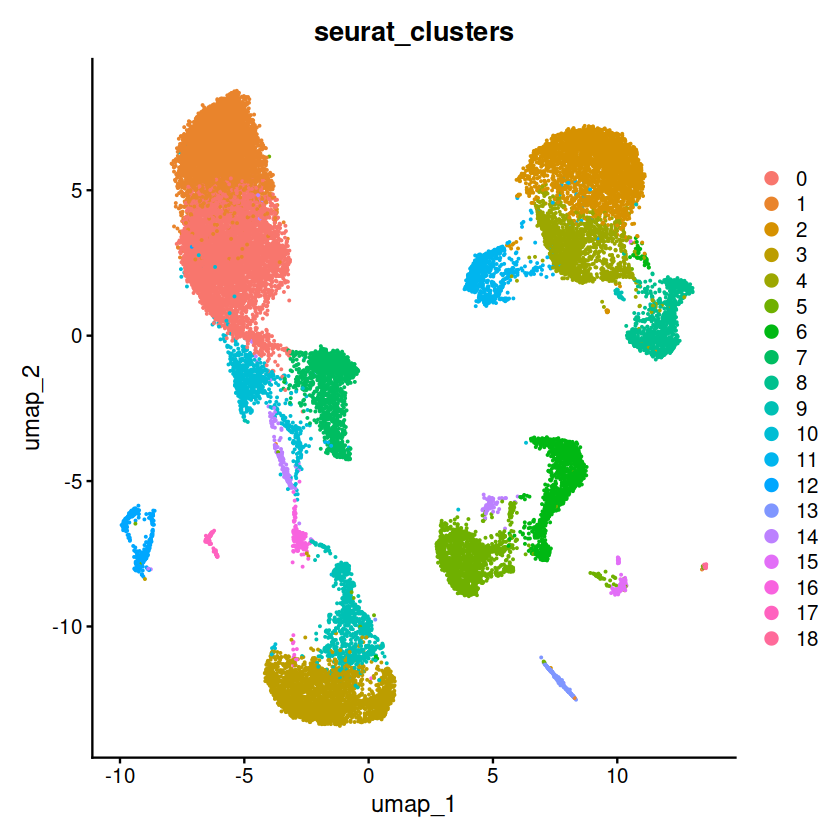

In [26]:
DimPlot(scnew2, reduction = "umap", group.by = "seurat_clusters")

In [27]:
mtd = data.frame(scnew2@reductions$umap@cell.embeddings)
mtd$merged_clusters = scnew2$seurat_clusters
mtd$before_clusters = scnew$RNA_snn_res.0.5
mtd$batch = scnew2$dataset
mtd[1:2,]

umap_1    umap_2    merged_clusters
stage16_sample1_AAACCCACAGCTGTCG-1 -5.166674 -1.733587 10             
stage16_sample1_AAACCCACATGTGACT-1  6.798470 -7.582160 6              
                                   before_clusters batch
stage16_sample1_AAACCCACAGCTGTCG-1 9               s1   
stage16_sample1_AAACCCACATGTGACT-1 12              s1

In [28]:
# save cluster and umap from merging all batches
write.table(mtd, file = 'stage16_merged_batch_seurat_clusters.csv', sep = ',', row.names = T,
           col.names = T, quote = F)

In [ ]:
# ..... mixing between batches ..... #

In [29]:
# load metadata
mtd = read.delim('stage16_merged_batch_seurat_clusters.csv', sep = ',')
unique(mtd$batch)

[1] "s1" "s2" "s3"

In [30]:
tab1 = mtd %>% group_by(merged_clusters) %>% reframe(s1 = sum(batch=='s1'), s2 = sum(batch=='s2'),
                                                    s3 = sum(batch=='s3'))
tab2 = as.matrix(tab1[,-1])
rownames(tab2) = unlist(tab1[,1])

In [31]:
# mixing - p-values
p.values <- clusterAbundanceTest(tab2)
p.values

0             1             2             3             4 
 0.000000e+00  0.000000e+00  3.005680e-18  4.109762e-06  9.030532e-18 
            5             6             7             8             9 
9.804705e-250  4.385784e-47 9.849870e-138  3.377283e-97  4.002459e-48 
           10            11            12            13            14 
 1.847868e-09  1.286367e-04  2.362259e-09  4.348112e-01  2.195287e-03 
           15            16            17            18 
 2.410531e-14  9.602734e-01  2.273922e-08  1.979632e-09

In [32]:
# mixing - relative abundances from diff batches
rv<- clusterAbundanceVar(tab2)

# Also printing the percentage of cells in each cluster in each batch:
percent <- t(t(tab2)/colSums(tab2)) * 100 
df <- DataFrame(Batch=unclass(percent), var=rv)
df[order(df$var, decreasing=TRUE),]

DataFrame with 19 rows and 4 columns
     Batch.s1  Batch.s2  Batch.s3        var
    <numeric> <numeric> <numeric>  <numeric>
5     7.63511  0.387693  11.86588    6.22888
0     2.71261 43.339107   6.37375    4.09270
1    32.75031  3.901675  28.38560    2.87778
8     5.66611  0.923864   5.95462    2.12319
7     1.31965  8.545740   3.15074    1.69690
...       ...       ...       ...        ...
11   2.482195  3.101543  2.110132 0.07180399
2    9.499372 13.462014 10.463940 0.06620110
3    9.666946  9.997525  7.775690 0.03783383
13   1.162547  1.352800  1.214048 0.01080564
16   0.544617  0.560917  0.578118 0.00131611

In [33]:
# ..... preserving biological heterogeneity ..... #
# checking mapping before and after correction

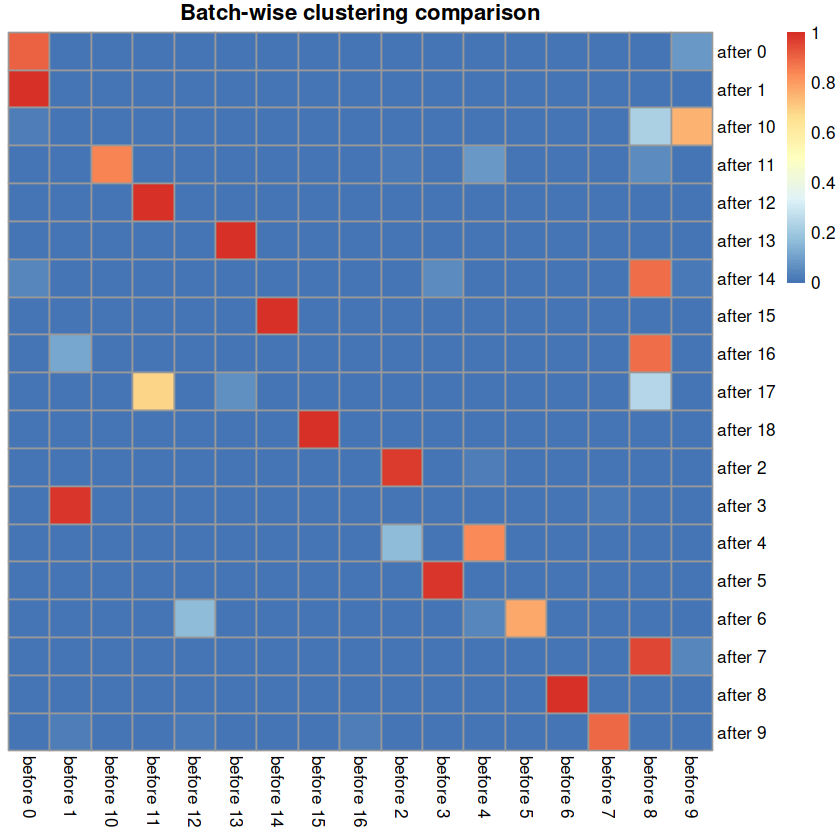

In [34]:
# For each batch:
tab4k <- nestedClusters(ref=paste("before", mtd$before_clusters[scnew2$dataset=='s1']),
                        alt=paste("after", mtd$merged_clusters[scnew2$dataset=='s1']))
pheatmap(tab4k$proportions, cluster_row=FALSE, cluster_col=FALSE,
                   main="Batch-wise clustering comparison")

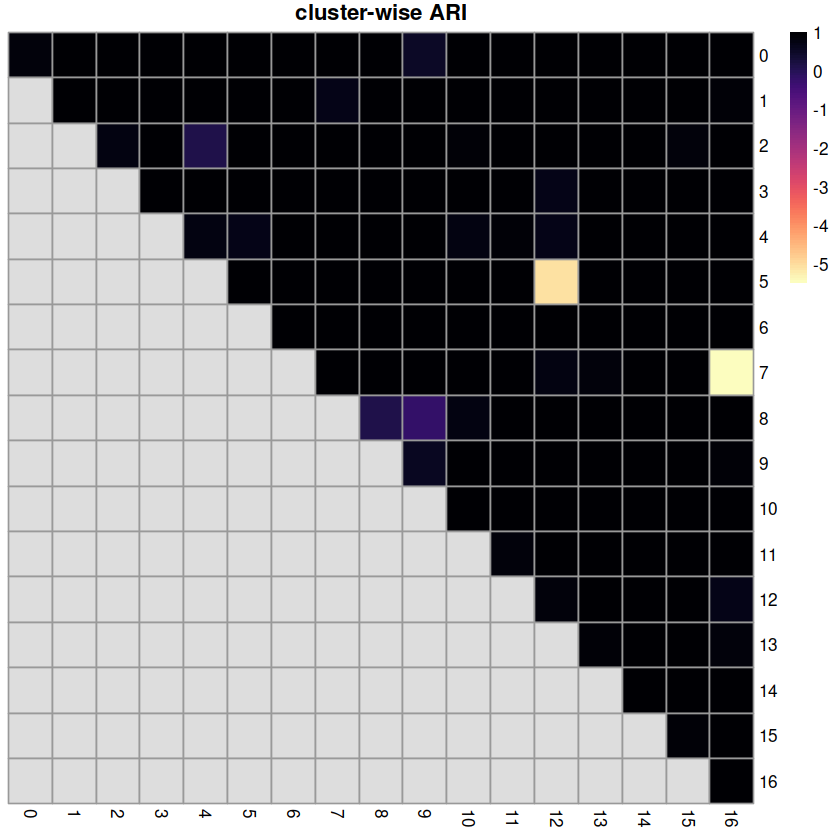

In [35]:
# For each batch - ARI per cluster
tab_ari <- pairwiseRand(mtd$before_clusters[scnew2$dataset=='s1'],
                       mtd$merged_clusters[scnew2$dataset=='s1'])
pheatmap(tab_ari, cluster_row=FALSE, cluster_col=FALSE,
    col=rev(viridis::magma(100)), main="cluster-wise ARI")